In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *
from src.mdp import VI_Solver

import pandas as pd
import numpy as np
import cupy as cp
import cv2

# Ground Air Model definition

In [2]:
env_x = [-2,10]
env_y = [-1,1]
points_per_unit = 30

width = ((env_x[1] - env_x[0]) * points_per_unit) + 1
height = ((env_y[1] - env_y[0]) * points_per_unit) + 1

env_shape = [height, width]
state_count = width * height
print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: [61, 361]
State count: 22021


In [3]:
# Data loading
nose_data = pd.read_csv('./Data/statistics_abs_nose_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T
ground_data = pd.read_csv('./Data/statistics_abs_ground_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T

nose_data = cv2.resize(nose_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))
ground_data = cv2.resize(ground_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))

nose_data_padded = np.zeros(env_shape)
nose_data_padded[15:46, 60:181] = nose_data

ground_data_padded = np.zeros(env_shape)
ground_data_padded[15:46, 60:181] = ground_data

nose_data = nose_data_padded
ground_data = ground_data_padded

In [4]:
# goal state
goal_state_coords = [30,60]
goal_state = (goal_state_coords[0] * env_shape[1]) + goal_state_coords[1]

print(f'Goal state: {goal_state}')

Goal state: 10890


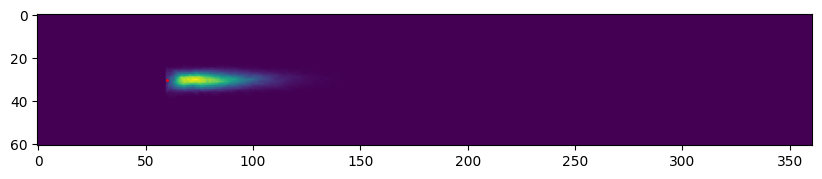

In [5]:
plt.figure(figsize=(10,20))
plt.imshow(ground_data)
plt.scatter(goal_state_coords[1], goal_state_coords[0], c='red',s=1)

In [6]:
# observation matrix
observations = np.empty((state_count, 6, 3)) # 6-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:5,0] = (1 - ground_data.ravel()[:,None])
observations[:,:5,1] = ground_data.ravel()[:,None]

observations[:,5,0] = (1 - nose_data.ravel())
observations[:,5,1] = nose_data.ravel()

# Detection of goal
observations[:,:,2] = 0.0
observations[goal_state,:,:] = 0.0
observations[goal_state,:,2] = 1.0

In [7]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [8]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 6, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else (state_count - row_w) + s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s % row_w # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West
    reachable_states[s,4,0] = s # Doesn't move and sniff ground
    reachable_states[s,5,0] = s # Doesn't move and sniff air

reachable_states = np.array(reachable_states)

In [9]:
# Start belief
start = np.zeros(env_shape)
start[15:46,60:316] = 1.0
start /= np.sum(start)

In [10]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O_Ground','O_Air'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    observation_table=observations,
    end_states=[goal_state],
    start_probabilities=start.ravel()
)

[11/25/2023, 22:44:09] Instantiation of MDP Model:
[11/25/2023, 22:44:09] - 22021 states
[11/25/2023, 22:44:09] - 6 actions
[11/25/2023, 22:44:09] - At most 1 reachable states per state-action pair
[11/25/2023, 22:44:09] - Starting generation of transitions table
[11/25/2023, 22:44:09]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[11/25/2023, 22:44:09]     > Done in 0.000s
[11/25/2023, 22:44:09] - Generation of state grid
[11/25/2023, 22:44:09] - Generating start probabilities table
[11/25/2023, 22:44:09] - Starting computation of reachable state probabilities from transition data
[11/25/2023, 22:44:09]     > Done in 0.000s

[11/25/2023, 22:44:09] POMDP particular parameters:
[11/25/2023, 22:44:09] - 3 observations
[11/25/2023, 22:44:09] - Starting of transitional observations for reachable states table
[11/25/2023, 22:44:09]     > Done in 0.004s
[11/25/2

## Make sure it is correct with MDP solving

In [11]:
solver = VI_Solver(eps=1e-6)
mdp_solution, history = solver.solve(model, use_gpu=True)
print(history.summary)

[11/25/2023, 22:44:09] Sending Model to GPU...
[11/25/2023, 22:44:09]     > Done in 0.212s


  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 22021-state, 6-action
  - Converged in 918 iterations and 2.1180 seconds
  - Took on average 0.0023s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


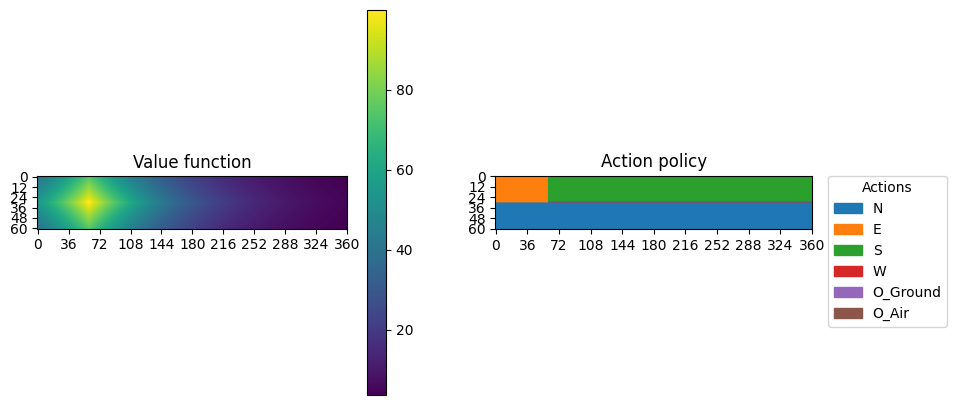

In [12]:
mdp_solution.plot()

## Saving

In [13]:
# model.save('Alt_WrapVert_GroundAir')

# Ground only model definition

In [14]:
# observation matrix
observations = np.empty((state_count, 5, 3)) # 5-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:,0] = (1 - ground_data.ravel()[:,None])
observations[:,:,1] = ground_data.ravel()[:,None]

# Detection of goal
observations[:,:,2] = 0.0
observations[goal_state,:,:] = 0.0
observations[goal_state,:,2] = 1.0

In [15]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 5, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else (state_count - row_w) + s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s % row_w # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West
    reachable_states[s,4,0] = s # Doesn't move and sniff ground

reachable_states = np.array(reachable_states)

In [16]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O_Ground'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    observation_table=observations,
    end_states=[goal_state],
    start_probabilities=start.ravel()
)

[11/25/2023, 22:44:12] Instantiation of MDP Model:
[11/25/2023, 22:44:12] - 22021 states
[11/25/2023, 22:44:12] - 5 actions
[11/25/2023, 22:44:12] - At most 1 reachable states per state-action pair
[11/25/2023, 22:44:12] - Starting generation of transitions table
[11/25/2023, 22:44:12]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[11/25/2023, 22:44:12]     > Done in 0.000s
[11/25/2023, 22:44:12] - Generation of state grid
[11/25/2023, 22:44:12] - Generating start probabilities table
[11/25/2023, 22:44:12] - Starting computation of reachable state probabilities from transition data
[11/25/2023, 22:44:12]     > Done in 0.000s

[11/25/2023, 22:44:12] POMDP particular parameters:
[11/25/2023, 22:44:12] - 3 observations
[11/25/2023, 22:44:12] - Starting of transitional observations for reachable states table
[11/25/2023, 22:44:12]     > Done in 0.007s
[11/25/2

## Make sure it is correct with MDP solving

In [17]:
solver = VI_Solver(eps=1e-6)
mdp_solution, history = solver.solve(model, use_gpu=True)
print(history.summary)

[11/25/2023, 22:44:12] Sending Model to GPU...
[11/25/2023, 22:44:12]     > Done in 0.004s


  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 22021-state, 5-action
  - Converged in 918 iterations and 2.0217 seconds
  - Took on average 0.0022s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


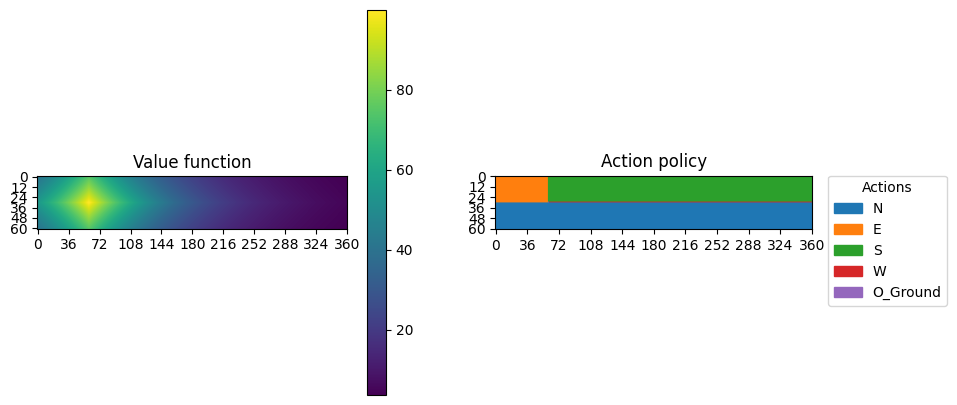

In [18]:
mdp_solution.plot()

In [19]:
a = Agent(model, mdp_solution)

a.run_n_simulations_parallel()

  0%|          | 0/1000 [00:00<?, ?it/s]

All 1000 simulations done in 377.205s:
	- Simulations reached goal: 910/1000 (90 failures)
	- Average step count: 454.555
	- Average total rewards: 0.91
	- Average discounted rewards (ADR): 0.10076058466131387


([0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


## Saving

In [26]:
# model.save('Alt_WrapVert_GroundOnly')